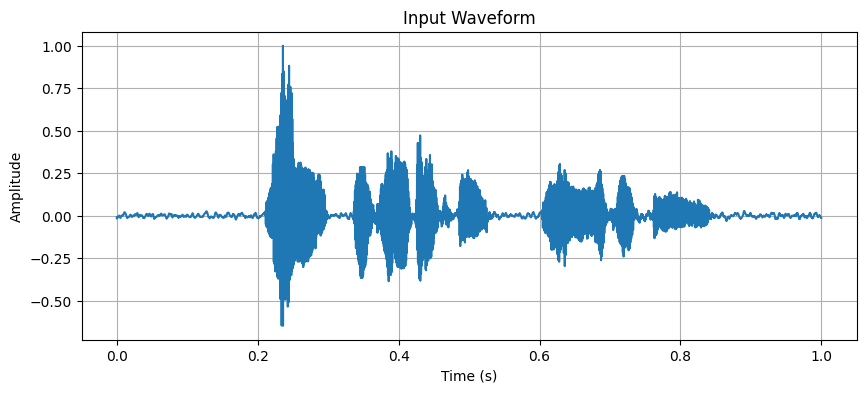

1/1 [==============================] - 4s 4s/step


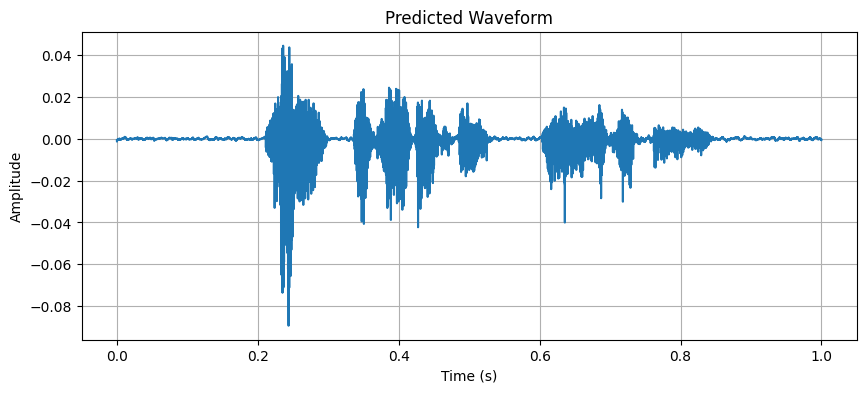

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import librosa

def unet_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv1D(64, 3, activation='relu', padding='same')(inputs)
    pool1 = layers.MaxPooling1D(pool_size=2)(conv1)

    conv2 = layers.Conv1D(128, 3, activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling1D(pool_size=2)(conv2)

    # Decoder
    up1 = layers.UpSampling1D(size=2)(pool2)
    concat1 = layers.Concatenate()([conv2, up1])
    conv3 = layers.Conv1D(64, 3, activation='relu', padding='same')(concat1)

    up2 = layers.UpSampling1D(size=2)(conv3)
    concat2 = layers.Concatenate()([conv1, up2])
    output = layers.Conv1D(1, 3, activation='tanh', padding='same')(concat2)

    model = models.Model(inputs=inputs, outputs=output)
    return model

def load_audio_file(file_path):
    audio_data, sampling_rate = librosa.load(file_path, sr=None)
    return audio_data, sampling_rate

def main():
    audio_file_path = "/content/samples_msp_4_msp.4.4.lr.wav"

    audio_data, _ = load_audio_file(audio_file_path)

    audio_data /= np.max(np.abs(audio_data))

    input_shape = (None, 1)
    model = unet_model(input_shape)

    plt.figure(figsize=(10, 4))
    plt.title('Input Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.plot(np.arange(len(audio_data)) / len(audio_data), audio_data)
    plt.grid(True)
    plt.show()

    audio_data = np.expand_dims(audio_data, axis=0)
    audio_data = np.expand_dims(audio_data, axis=-1)

    prediction = model.predict(audio_data)

    plt.figure(figsize=(10, 4))
    plt.title('Predicted Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.plot(np.arange(len(prediction.squeeze())) / len(prediction.squeeze()), prediction.squeeze())
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()


1/1 [==============================] - 1s 1s/step


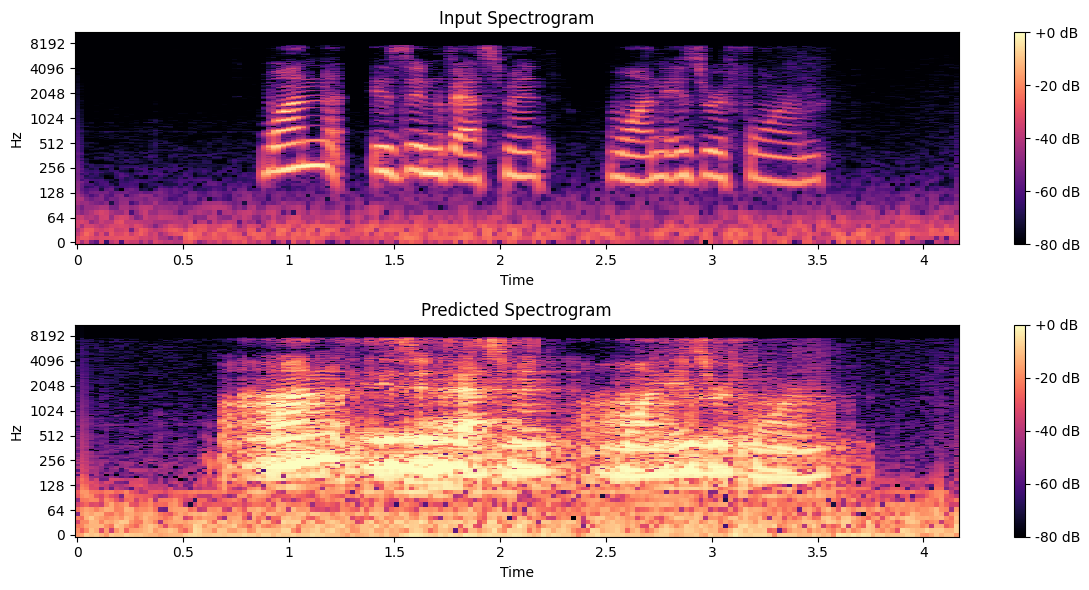

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Lambda
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

def unet_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)

    # Decoder
    up1 = layers.UpSampling2D(size=(2, 2))(conv3)
    concat1 = Lambda(lambda x: tf.concat([x[0][:, :tf.shape(x[1])[1], :, :], x[1]], axis=-1))([conv2, up1])
    conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat1)

    up2 = layers.UpSampling2D(size=(2, 2))(conv4)
    concat2 = Lambda(lambda x: tf.concat([x[0][:, :tf.shape(x[1])[1], :, :], x[1]], axis=-1))([conv1, up2])
    output = layers.Conv2D(1, (3, 3), activation='tanh', padding='same')(concat2)

    model = models.Model(inputs=inputs, outputs=output)
    return model

def load_audio_file(file_path, target_sr=22050):
    audio_data, sampling_rate = librosa.load(file_path, sr=target_sr)
    return audio_data, sampling_rate

def main():
    audio_file_path = "/content/samples_msp_4_msp.4.4.hr.wav"

    target_sr = 22050
    audio_data, sampling_rate = load_audio_file(audio_file_path, target_sr)

    spectrogram = np.abs(librosa.stft(audio_data))

    # Reshape spectrogram to fit the model input
    spectrogram = np.expand_dims(spectrogram, axis=0)
    spectrogram = np.expand_dims(spectrogram, axis=-1)

    input_shape = (spectrogram.shape[1], spectrogram.shape[2], 1)
    model = unet_model(input_shape)

    prediction = model.predict(spectrogram)

    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    librosa.display.specshow(librosa.amplitude_to_db(spectrogram.squeeze(), ref=np.max), sr=sampling_rate, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Input Spectrogram')

    plt.subplot(2, 1, 2)
    librosa.display.specshow(librosa.amplitude_to_db(prediction.squeeze(), ref=np.max), sr=sampling_rate, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Predicted Spectrogram')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


1/1 [==============================] - 1s 963ms/step


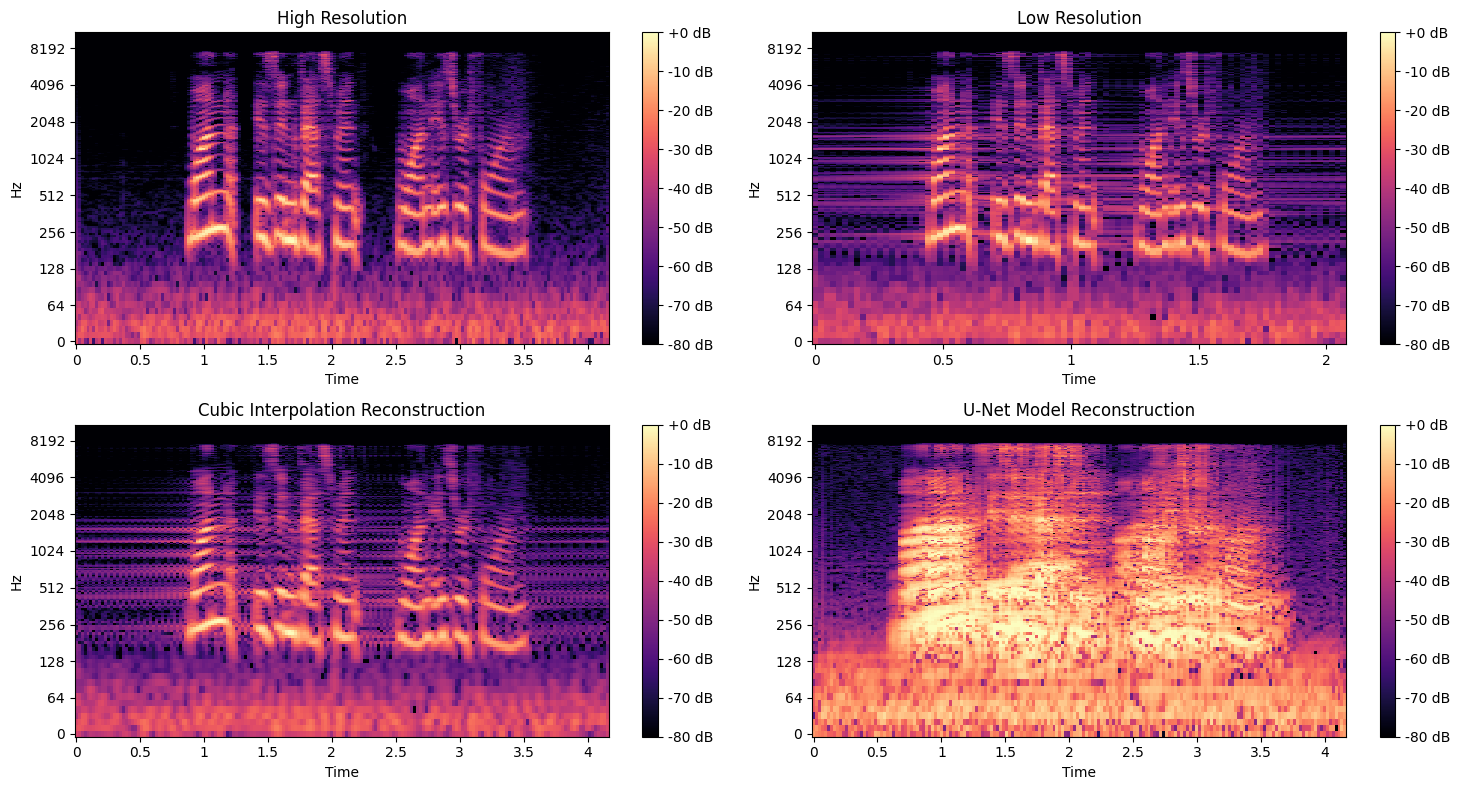

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Lambda
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from scipy.signal import resample

def unet_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)

    # Decoder
    up1 = layers.UpSampling2D(size=(2, 2))(conv3)
    concat1 = Lambda(lambda x: tf.concat([x[0][:, :tf.shape(x[1])[1], :, :], x[1]], axis=-1))([conv2, up1])
    conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat1)

    up2 = layers.UpSampling2D(size=(2, 2))(conv4)
    concat2 = Lambda(lambda x: tf.concat([x[0][:, :tf.shape(x[1])[1], :, :], x[1]], axis=-1))([conv1, up2])
    output = layers.Conv2D(1, (3, 3), activation='tanh', padding='same')(concat2)

    model = models.Model(inputs=inputs, outputs=output)
    return model

def load_audio_file(file_path, target_sr=22050):
    audio_data, sampling_rate = librosa.load(file_path, sr=target_sr)
    return audio_data, sampling_rate

def main():
    audio_file_path = "/content/samples_msp_4_msp.4.4.hr.wav"

    target_sr = 22050
    audio_data, sampling_rate = load_audio_file(audio_file_path, target_sr)

    # Original high-resolution signal
    high_resolution = np.abs(librosa.stft(audio_data))

    # Low-resolution version
    low_resolution = resample(high_resolution, high_resolution.shape[1] // 2, axis=1)

    # Cubic interpolation reconstruction
    cubic_reconstruction = resample(low_resolution, high_resolution.shape[1], axis=1)

    # Reshape spectrogram to fit the model input
    spectrogram = np.abs(librosa.stft(audio_data))
    spectrogram = np.expand_dims(spectrogram, axis=0)
    spectrogram = np.expand_dims(spectrogram, axis=-1)

    input_shape = (spectrogram.shape[1], spectrogram.shape[2], 1)
    model = unet_model(input_shape)

    # U-Net model reconstruction
    unet_reconstruction = model.predict(spectrogram)

    plt.figure(figsize=(15, 8))

    # Plotting original high-resolution signal
    plt.subplot(2, 2, 1)
    librosa.display.specshow(librosa.amplitude_to_db(high_resolution.squeeze(), ref=np.max), sr=sampling_rate, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('High Resolution')

    # Plotting low-resolution version
    plt.subplot(2, 2, 2)
    librosa.display.specshow(librosa.amplitude_to_db(low_resolution.squeeze(), ref=np.max), sr=sampling_rate, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Low Resolution')

    # Plotting cubic interpolation reconstruction
    plt.subplot(2, 2, 3)
    librosa.display.specshow(librosa.amplitude_to_db(cubic_reconstruction.squeeze(), ref=np.max), sr=sampling_rate, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Cubic Interpolation Reconstruction')

    # Plotting U-Net model reconstruction
    plt.subplot(2, 2, 4)
    librosa.display.specshow(librosa.amplitude_to_db(unet_reconstruction.squeeze(), ref=np.max), sr=sampling_rate, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('U-Net Model Reconstruction')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


In [11]:
def create_unet_comparison_table(operation_names, unet_descriptions):
    """
    Create a tabular format comparison of U-Net operations based on custom parameters.

    Parameters:
        operation_names (list of str): List of operation names.
        unet_descriptions (list of str): List of U-Net operation descriptions corresponding to each operation.

    Returns:
        str: Tabular format comparison of U-Net operations.
    """

    if len(operation_names) != len(unet_descriptions):
        raise ValueError("Number of operation names and U-Net descriptions should be the same.")

    # Header
    table = "| Operation                        | U-Net Description                                                                                                 |\n"
    table += "|----------------------------------|------------------------------------------------------------------------------------------------------------------|\n"

    for name, unet_desc in zip(operation_names, unet_descriptions):
        name = name.ljust(32)
        unet_desc = unet_desc.ljust(102)
        table += f"| {name} | {unet_desc} |\n"

    return table

operation_names = [
    "Generating Low-Res Spectrogram",
    "Reconstructing High-Res Spectrogram (Baseline)",
    "Reconstructing High-Res Spectrogram (Our)",
    "Model Prediction"
]

unet_descriptions = [
    "X_downsampled = U-Net(Downsample(X)), where Downsample could involve averaging or subsampling",
    "X_reconstructed = U-Net(Upsample(X_low-res)), where Upsample involves interpolation",
    "X_reconstructed = U-Net(Upsample(X_predicted)), where Upsample involves interpolation",
    "Y = U-Net(activation(U-Net(X_input * W + b)))"
]

unet_comparison_table = create_unet_comparison_table(operation_names, unet_descriptions)

print(unet_comparison_table)


| Operation                        | U-Net Description                                                                                                 |
|----------------------------------|------------------------------------------------------------------------------------------------------------------|
| Generating Low-Res Spectrogram   | X_downsampled = U-Net(Downsample(X)), where Downsample could involve averaging or subsampling          |
| Reconstructing High-Res Spectrogram (Baseline) | X_reconstructed = U-Net(Upsample(X_low-res)), where Upsample involves interpolation                    |
| Reconstructing High-Res Spectrogram (Our) | X_reconstructed = U-Net(Upsample(X_predicted)), where Upsample involves interpolation                  |
| Model Prediction                 | Y = U-Net(activation(U-Net(X_input * W + b)))                                                          |

